In [1]:
# Import libraries
import pandas as pd
import numpy as np
import pingouin as pg 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
import scikit_posthocs as sp
from scipy.stats import binom, poisson, norm
from scipy.stats import kruskal
warnings.filterwarnings('ignore') # Suppress warnings

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', None)

In [2]:
# Read in the data

f = open('Dairy_aggregate.xlsx', 'rb').read()
dairy_ag_df = pd.read_excel(f)

f = open('Dairy_unmerged.xlsx', 'rb').read()
dairy_df = pd.read_excel(f)

dairy_total_df = pd.read_csv("FAOSTAT_data_en_4-28-2024.csv")

In [227]:
# Check the data

dairy_total_df.shape
dairy_total_df.head()

(6736, 15)

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,40,Austria,5510,Production,22241.01,Butter of cow milk,2004,2004,t,32937.0,A,Official figure,NaN
1,QCL,Crops and livestock products,40,Austria,5510,Production,22241.01,Butter of cow milk,2005,2005,t,31208.0,A,Official figure,NaN
2,QCL,Crops and livestock products,40,Austria,5510,Production,22241.01,Butter of cow milk,2006,2006,t,33059.0,A,Official figure,NaN
3,QCL,Crops and livestock products,40,Austria,5510,Production,22241.01,Butter of cow milk,2007,2007,t,34667.0,A,Official figure,NaN
4,QCL,Crops and livestock products,40,Austria,5510,Production,22241.01,Butter of cow milk,2008,2008,t,33517.0,A,Official figure,NaN


In [228]:
# Check the data types for each column

dairy_total_df.Item.value_counts()
dairy_total_df.Element.value_counts()
dairy_total_df.Unit.value_counts()

Item
Raw milk of cattle                                 1026
Raw milk of goats                                   808
Raw milk of sheep                                   651
Butter of cow milk                                  464
Skim milk of cows                                   453
Cheese from whole cow milk                          450
Skim milk and whey powder                           407
Whole milk powder                                   389
Whole milk, evaporated                              379
Whole milk, condensed                               328
Cheese from milk of sheep, fresh or processed       286
Cheese from milk of goats, fresh or processed       257
Cheese from skimmed cow milk                        243
Buttermilk, dry                                     239
Raw milk of buffalo                                 212
Skim milk, condensed                                 64
Skim milk, evaporated                                49
Cheese from milk of buffalo, fresh or proce

Element
Production    5520
Yield         1216
Name: count, dtype: int64

Unit
t           5520
100 g/An    1216
Name: count, dtype: int64

In [229]:
# Filter the data from FAO to only include the total production and yield of raw milk of cattle and buffalo

dairy_total_df = dairy_total_df[(dairy_total_df.Item == 'Raw milk of cattle') | (dairy_total_df.Item == 'Raw milk of buffalo')].reset_index(drop=True)
dairy_total_df.head(100)

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,40,Austria,5510,Production,2212.0,Raw milk of buffalo,2018,2018,t,0.0,A,Official figure,NaN
1,QCL,Crops and livestock products,40,Austria,5510,Production,2212.0,Raw milk of buffalo,2019,2019,t,0.0,A,Official figure,NaN
2,QCL,Crops and livestock products,40,Austria,5510,Production,2212.0,Raw milk of buffalo,2020,2020,t,0.0,A,Official figure,NaN
3,QCL,Crops and livestock products,40,Austria,5510,Production,2212.0,Raw milk of buffalo,2021,2021,t,0.0,A,Official figure,NaN
4,QCL,Crops and livestock products,40,Austria,5510,Production,2212.0,Raw milk of buffalo,2022,2022,t,0.0,A,Official figure,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,QCL,Crops and livestock products,100,Bulgaria,5510,Production,2212.0,Raw milk of buffalo,2008,2008,t,7173.0,A,Official figure,NaN
96,QCL,Crops and livestock products,100,Bulgaria,5420,Yield,2212.0,Raw milk of buffalo,2009,2009,100 g/An,13222.0,A,Official figure,NaN
97,QCL,Crops and livestock products,100,Bulgaria,5510,Production,2212.0,Raw milk of buffalo,2009,2009,t,7022.0,A,Official figure,NaN
98,QCL,Crops and livestock products,100,Bulgaria,5420,Yield,2212.0,Raw milk of buffalo,2010,2010,100 g/An,15876.0,A,Official figure,NaN


In [230]:
# Create new dataframe selecting columns of interest from previous dataframe. Group data by Member State, Year and Element and Values for raw milk are summed for each group

dairy_output_df = dairy_total_df[[ 'Year', 'Area', 'Element', 'Value']].groupby(by=['Area', 'Year', 'Element']).sum().reset_index()
dairy_output_df.rename(columns={'Area': 'Member State'}, inplace=True)
dairy_output_df['Member State'].replace({'Netherlands (Kingdom of the)': 'Netherlands'}, inplace=True)

dairy_output_df.head()

,Member State,Year,Element,Value
0,Austria,2004,Production,3137322.0
1,Austria,2004,Yield,58019.0
2,Austria,2005,Production,3113658.0
3,Austria,2005,Yield,57828.0
4,Austria,2006,Production,3146657.0


In [231]:
dairy_output_df.dtypes

Member State     object
Year              int64
Element          object
Value           float64
dtype: object

In [232]:
# Pivot the data to create columns for 'Production' and 'Yield' from 'Element' and assign 'Value' in each column to respective rows
dairy_output_df_pivoted =  dairy_output_df.pivot(index=['Year', 'Member State'], columns='Element', values='Value').reset_index() # Create columns out of individual rows and assign 'Value' column
dairy_output_df_pivoted.rename(columns={'Production': 'Production_tonnes', 'Yield': 'Yield_100g_per_An'}, inplace=True)
dairy_output_df_pivoted.head()

# Convert Yield from 100g per animal to Kg per animal
dairy_output_df_pivoted.Yield_100g_per_An = dairy_output_df_pivoted.Yield_100g_per_An / 10 # Convert to kg per animal
dairy_output_df_pivoted.rename(columns={'Yield_100g_per_An': 'Yield_Kg_per_An'}, inplace=True)
dairy_output_df_pivoted.head()

# Derive number of animals from Production and Yield
dairy_output_df_pivoted['Derived_Animal_Number'] = round(dairy_output_df_pivoted['Production_tonnes'] / (dairy_output_df_pivoted['Yield_Kg_per_An'] / 1000)).astype('int') # Converting Yield_Kg_per_An into Tonnes & then deriving number of animals
dairy_output_df_pivoted.head()


Element,Year,Member State,Production_tonnes,Yield_100g_per_An
0,2004,Austria,3137322.0,58019.0
1,2004,Belgium,3060000.0,56387.0
2,2004,Bulgaria,1350979.0,50878.0
3,2004,Croatia,684379.0,28749.0
4,2004,Cyprus,151220.0,73000.0


Element,Year,Member State,Production_tonnes,Yield_Kg_per_An
0,2004,Austria,3137322.0,5801.9
1,2004,Belgium,3060000.0,5638.7
2,2004,Bulgaria,1350979.0,5087.8
3,2004,Croatia,684379.0,2874.9
4,2004,Cyprus,151220.0,7300.0


Element,Year,Member State,Production_tonnes,Yield_Kg_per_An,Derived_Animal_Number
0,2004,Austria,3137322.0,5801.9,540740
1,2004,Belgium,3060000.0,5638.7,542678
2,2004,Bulgaria,1350979.0,5087.8,265533
3,2004,Croatia,684379.0,2874.9,238053
4,2004,Cyprus,151220.0,7300.0,20715


In [233]:
# Calculate the median of Production, Yield and Derived Animal Number for each Member State over time period and split into percentiles

median_df = pd.DataFrame(dairy_output_df_pivoted['Member State'].unique().tolist(), columns=['Member State'])

def calc_median(df, column_name):
  df = df[['Member State', column_name]]
  return df.groupby(by=['Member State'], as_index=False).median()

for column_name in ['Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number']:
    median_df = median_df.merge(calc_median(dairy_output_df_pivoted, column_name).rename(columns={column_name: column_name + '_median'}), on=['Member State'])
    median_df[column_name + '_percentiles'] =  pd.qcut(median_df[column_name + '_median'] , np.linspace(0,1,6), labels=range(1, 6, 1))


median_df.head()

,Member State,Production_tonnes_median,Production_tonnes_percentiles,Yield_Kg_per_An_median,Yield_Kg_per_An_percentiles,Derived_Animal_Number_median,Derived_Animal_Number_percentiles
0,Austria,3393057.0,4,6459.8,2,532867.0,4
1,Belgium,3474000.0,4,7107.5,3,523284.0,4
2,Bulgaria,1101115.0,2,5025.6,1,210604.0,2
3,Croatia,711400.0,1,4319.3,1,176399.0,2
4,Cyprus,162373.0,1,7502.6,4,20715.0,1


In [234]:
dairy_output_df_pivoted = dairy_output_df_pivoted.merge(median_df, on=['Member State'])
dairy_output_df_pivoted.head()

,Year,Member State,Production_tonnes,Yield_Kg_per_An,Derived_Animal_Number,Production_tonnes_median,Production_tonnes_percentiles,Yield_Kg_per_An_median,Yield_Kg_per_An_percentiles,Derived_Animal_Number_median,Derived_Animal_Number_percentiles
0,2004,Austria,3137322.0,5801.9,540740,3393057.0,4,6459.8,2,532867.0,4
1,2004,Belgium,3060000.0,5638.7,542678,3474000.0,4,7107.5,3,523284.0,4
2,2004,Bulgaria,1350979.0,5087.8,265533,1101115.0,2,5025.6,1,210604.0,2
3,2004,Croatia,684379.0,2874.9,238053,711400.0,1,4319.3,1,176399.0,2
4,2004,Cyprus,151220.0,7300.0,20715,162373.0,1,7502.6,4,20715.0,1


### Plotting & Assessing Dairy production across EU member states over time

In [235]:
# import dash library

from dash import Dash, dcc, html, Input, Output
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.tools as tls

In [353]:
# Create a Dash app to visualise Dairy output for european member states over time

app = Dash(__name__)

app.layout = html.Div([
    html.Div([
        dcc.Dropdown(
            id="metric",
            options=['Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number'],
            value="Production_tonnes",
        ),
        dcc.Checklist(
            options=[
                {"label": "80-100%", "value": 5},
                {"label": "60-80%", "value": 4},
                {"label": "40-60%", "value": 3},
                {"label": "20-40%", "value": 2},
                {"label": "0-20%", "value": 1},
            ],
            value=[4, 5],
            id="percentiles",
            inline=True,
        ),
    ],  style={'width': '30%', 'display': 'inline-block', "backgroundColor": "white"}),
    html.Div([
            dcc.Checklist(
                id="states",
                options=dairy_output_df_pivoted['Member State'].unique(),
                value=dairy_output_df_pivoted['Member State'].unique(),
            ),
        ], style={'width': '8%', 'float': 'left', 'display': 'inline-block', "backgroundColor": "white"}),
    html.Div([
            dcc.Graph(id="line-graph"),
    ],  style={'width': '92%', 'float': 'right', 'display': 'inline-block'}),
], style={"backgroundColor": "white"})


@app.callback(
    Output("line-graph", "figure"), 
    Input("metric", "value"),
    Input("states", "value"),
    Input('percentiles', 'value'),
)
def update_line_chart(metric, states, percentiles):
    data = dairy_output_df_pivoted[dairy_output_df_pivoted['Member State'].isin(states) & (dairy_output_df_pivoted[metric + '_percentiles'].isin(percentiles))]
    fig = px.line(data, x="Year", y=metric, color='Member State', title=f"Dairy {metric}")
    return fig


app.run_server(debug=True)

Validation of yield ranking of ireland within EU countries, https://www.irishexaminer.com/farming/arid-41257186.html (Find more legitimate source)

Does Irish Milk production differ significantly from that of a closely comparable country for output such as Denmark. Assess overall production for the time frame tested. Assess if there is a significant difference before and after removal of EU milk quotas in 2015.

Compare Irish animal number and milk yield before and after removal of EU milk quotas in 2015. What was the Irish approach to quota removal? Efficiency or Expansion? https://www.dlg.org/en/agriculture/topics/dlg-agrifuture-magazine/knowledge-skills/danish-milk-producers-efficiency-is-the-secret-of-their-success

Correlation of Dairy variables in Europe

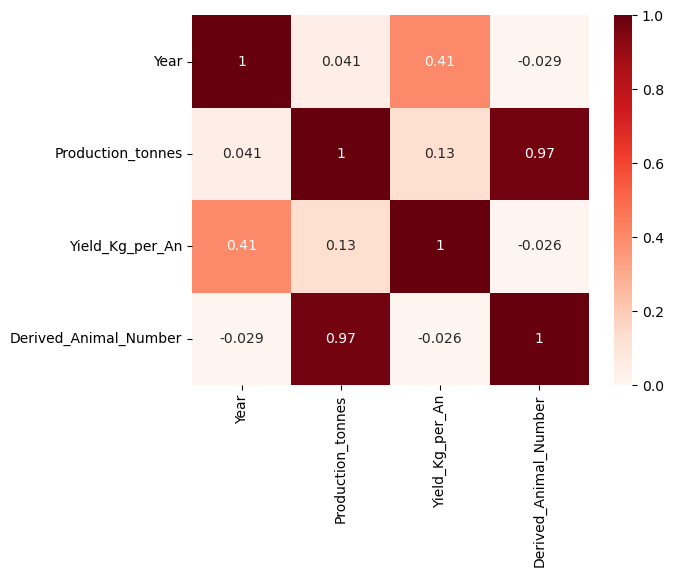

In [237]:
# Assessing the correlation of the different quantitative variables in the dataset of European milk production. Correlation matrix shows a moderate positive correlation between Year and Yield supporting a progression to an overall more efficient production.

corr = dairy_output_df_pivoted[['Year', 'Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number']].dropna().corr()
sns.heatmap(corr, cmap="Reds", annot=True, vmin=0, vmax=1);

Correlation of Dairy variables in Ireland

<Axes: >

<Axes: >

<Axes: >

<Axes: >

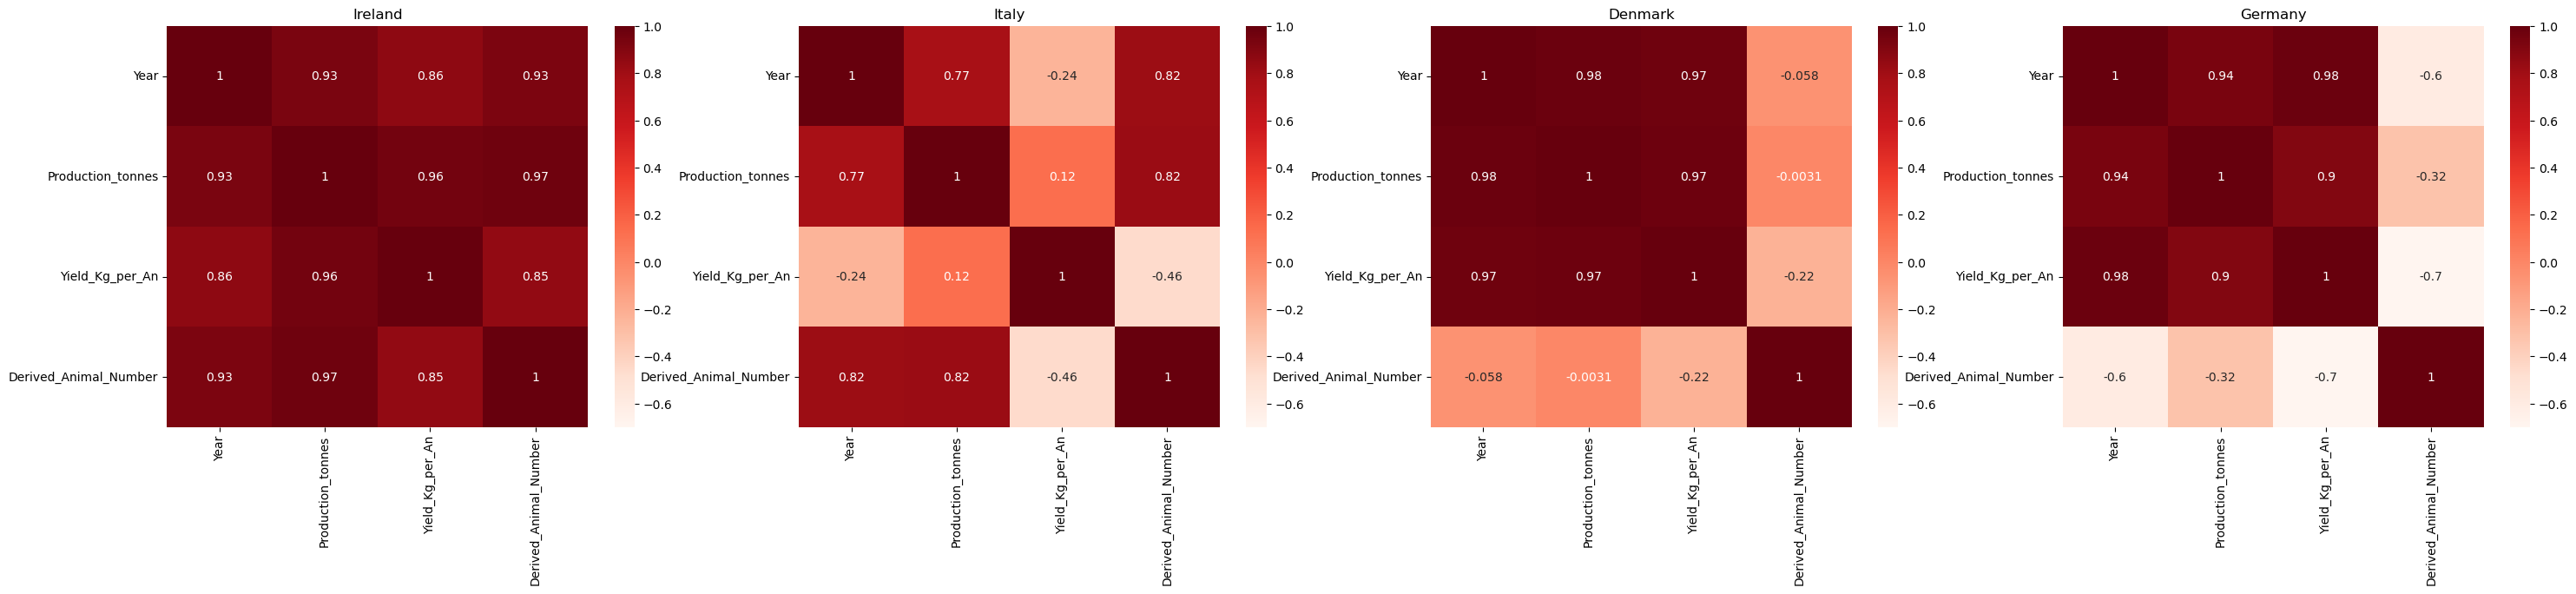

In [238]:
# Assessing the correlation of the different quantitative vriables in the dataset of IRISH milk production. 
# Correlation matrix shows a strong positive correlation between all variables, demonstrating an expected relationship between milk production and the number of animals / yield per animal. Yield exhibited the lowest correlation with all other variables,
# indicating that animal number is more associated with milk production in Ireland than yield/efficiency.

# Assessing the correlation of the different quantitative vriables in the dataset of DANISH milk production. 
# Correlation matrix shows a strong positive correlation between production, yield and year but not Animal number. Demonstrating a strong relationship between milk production and yield per animal. Yield exhibited the lowest correlation with all other variables,
# indicating that yield/efficiency is more associated with milk production in Denmark than scale.

countries_to_assess = ['Ireland', 'Italy', 'Denmark', 'Germany']

fig, axes = plt.subplots(1, len(countries_to_assess), figsize=(9 * len(countries_to_assess), 6))

for i, state in enumerate(countries_to_assess):
    corr = dairy_output_df_pivoted.loc[dairy_output_df_pivoted['Member State'] == state, ['Year', 'Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number']].dropna().corr()
    sns.heatmap(corr, cmap="Reds", annot=True, vmin=-0.7, vmax=1, ax=axes[i])
    _ = axes[i].set_title(state)

# Heatmap color scale limits to allow for direct comparison of correlation of variables for different countries without adjustment for correlation values obtained.


## Statistics

In [239]:
#Importing libraries

import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats import weightstats

#Importing the libraries
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy as scipy

from statsmodels.tsa.stattools import adfuller

### Visualising distribution of variables from all european member states

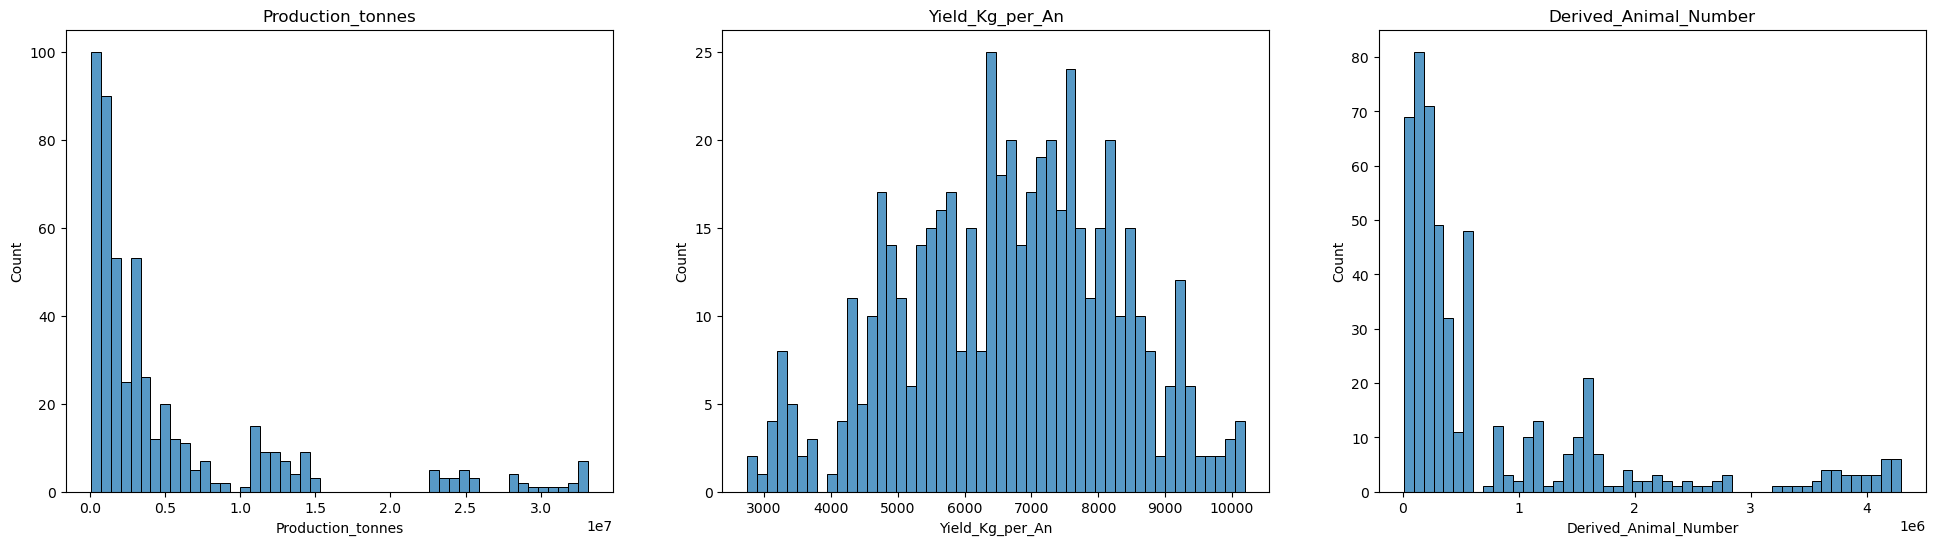

In [240]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

for i, column in enumerate(['Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number']):
    _ = sns.histplot(data=dairy_output_df_pivoted, x=column, bins=50, ax=axes[i])
    _ = axes[i].set_title(column)


In [241]:
dairy_output_df_pivoted.head()

,Year,Member State,Production_tonnes,Yield_Kg_per_An,Derived_Animal_Number,Production_tonnes_median,Production_tonnes_percentiles,Yield_Kg_per_An_median,Yield_Kg_per_An_percentiles,Derived_Animal_Number_median,Derived_Animal_Number_percentiles
0,2004,Austria,3137322.0,5801.9,540740,3393057.0,4,6459.8,2,532867.0,4
1,2004,Belgium,3060000.0,5638.7,542678,3474000.0,4,7107.5,3,523284.0,4
2,2004,Bulgaria,1350979.0,5087.8,265533,1101115.0,2,5025.6,1,210604.0,2
3,2004,Croatia,684379.0,2874.9,238053,711400.0,1,4319.3,1,176399.0,2
4,2004,Cyprus,151220.0,7300.0,20715,162373.0,1,7502.6,4,20715.0,1


## Condition 1- Normality of Distribution
## Asssessing normality of distribution of variables from all european member states (Alpha:0.05)

In [242]:
for i, column in enumerate(['Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number']):
    k2, p = stats.normaltest(dairy_output_df_pivoted[column])

    alpha = 0.05
    print(column)
    print("p = {:g}".format(p))

    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis (H0) can be rejected \n")
    else:
        print("The null hypothesis (H0) cannot be rejected \n")

Production_tonnes
p = 2.68534e-52
The null hypothesis (H0) can be rejected 

Yield_Kg_per_An
p = 0.00342301
The null hypothesis (H0) can be rejected 

Derived_Animal_Number
p = 1.61122e-43
The null hypothesis (H0) can be rejected 



### QQ plots visualises the normality of distribution of all variables across all EU member states. 

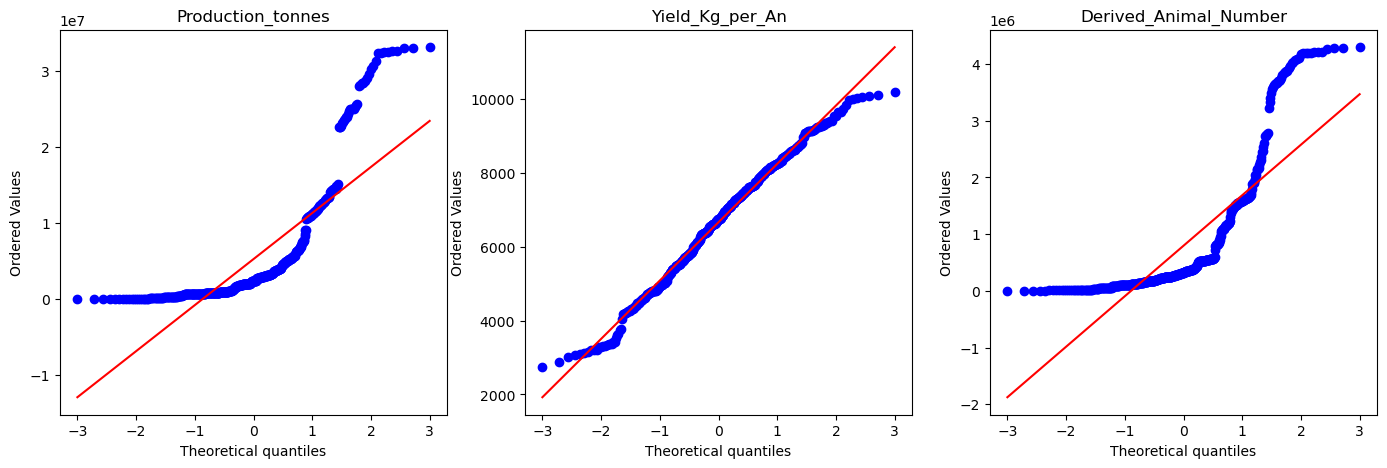

In [243]:
# Check normality of the data for Production & Yield & Number of animals
# Probability plot - QQ plot
# https://www.ucd.ie/ecomodel/Resources/QQplots_WebVersion.html

f, axes = plt.subplots(1, 3, figsize=(17, 5))

for i, column in enumerate(['Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number']):
   _ = stats.probplot(dairy_output_df_pivoted[column], plot=axes[i]);
   _ = axes[i].set_title(column);
f.show()

### QQ plots visually assessment of the normality of distribution of all variables in Ireland and Denmark. 

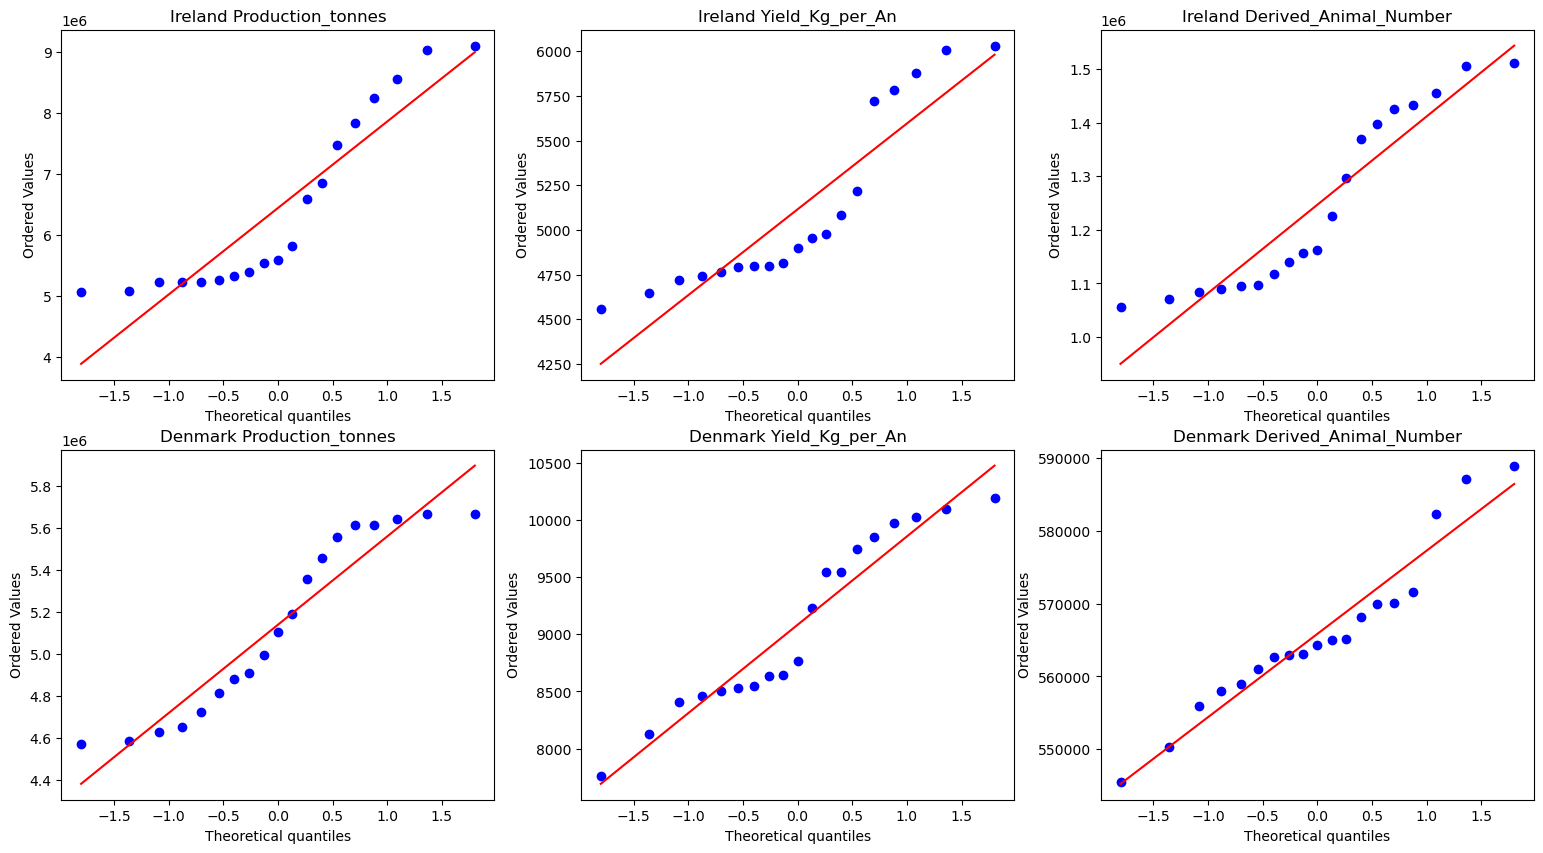

In [244]:
f, axes = plt.subplots(2, 3, figsize=(19, 10))

for i, state in enumerate(['Ireland', 'Denmark']): 
    state_data = dairy_output_df_pivoted[dairy_output_df_pivoted['Member State'] == state]
    for j, column in enumerate(['Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number']):
       _ = stats.probplot(state_data[column], plot=axes[i, j]);
       _ = axes[i, j].set_title(state + ' ' + column);

f.show()

In [245]:
for state in dairy_output_df_pivoted['Member State'].unique(): 
    print(state)

Austria
Belgium
Bulgaria
Croatia
Cyprus
Czechia
Denmark
Estonia
Finland
France
Germany
Greece
Hungary
Ireland
Italy
Latvia
Lithuania
Luxembourg
Malta
Netherlands
Poland
Portugal
Romania
Slovakia
Slovenia
Spain
Sweden


### Both Shapiro-Wilk and D'Agostino's K^2 normality tests are tested on all variables for all countries with alpha level cutoff of 0.1% to reduce the chance of false categorisation non-normal distribution

In [246]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [247]:
normality_test_results = []

for state in dairy_output_df_pivoted['Member State'].unique(): 
    state_data = dairy_output_df_pivoted[dairy_output_df_pivoted['Member State'] == state]
    for column in ['Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number']:
        shap_result = stats.shapiro(state_data[column]);
        k2, norm_result_pvalue = stats.normaltest(state_data[column])
        normality_test_results.append([state, column, shap_result.pvalue >= 0.05, shap_result.statistic, shap_result.pvalue, norm_result_pvalue >= 0.05, k2, norm_result_pvalue])

normality_test_results_df = pd.DataFrame(data=normality_test_results, columns=['Member State', 'Metric', 'shap_Normally_Distributed', 'shap_Statistic', 'shap_p-value', 'norm_Normally_Distributed', 'norm_k2', 'norm_p-value'])
normality_test_results_df.head(81)

,Member State,Metric,shap_Normally_Distributed,shap_Statistic,shap_p-value,norm_Normally_Distributed,norm_k2,norm_p-value
0,Austria,Production_tonnes,True,0.902781,0.054642,False,6.220597,0.044588
1,Austria,Yield_Kg_per_An,True,0.908392,0.069168,True,5.095477,0.078258
2,Austria,Derived_Animal_Number,True,0.927109,0.153174,True,3.307464,0.191335
3,Belgium,Production_tonnes,False,0.871462,0.015296,False,8.611601,0.013490
4,Belgium,Yield_Kg_per_An,False,0.879442,0.020996,False,10.671079,0.004817
...,...,...,...,...,...,...,...,...
76,Spain,Yield_Kg_per_An,True,0.938076,0.243408,True,3.074570,0.214964
77,Spain,Derived_Animal_Number,False,0.885687,0.027005,True,4.654433,0.097567
78,Sweden,Production_tonnes,True,0.931909,0.187784,True,2.351748,0.308549
79,Sweden,Yield_Kg_per_An,True,0.906181,0.063020,True,2.192182,0.334175


In [248]:
@interact
def show_normality_test_results(metric=['Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number'], is_shap_normally_distr=True, condition=['either (or)', 'both (and)'], is_dag_normally_distr=True):
    if condition == 'either (or)':
        res = normality_test_results_df[(normality_test_results_df['Metric'] == metric) & ((normality_test_results_df['shap_Normally_Distributed'] == is_shap_normally_distr) | (normality_test_results_df['norm_Normally_Distributed'] == is_dag_normally_distr))]
    else:
        res = normality_test_results_df[(normality_test_results_df['Metric'] == metric) & (normality_test_results_df['shap_Normally_Distributed'] == is_shap_normally_distr) & (normality_test_results_df['norm_Normally_Distributed'] == is_dag_normally_distr)]
    print('Size of the filtered DF: ', res.shape)
    return res

interactive(children=(Dropdown(description='metric', options=('Production_tonnes', 'Yield_Kg_per_An', 'Derived…

### Only Yield cannot reject the null hypothesis and is therefore the only variable which is normally distributed across >90% of european member states by either Shapiro-Wilks or D'Agostino normality tests. Belgium and Hungary are the only countries which do not have normal distribution for this variable.
Therefore parametric tests will be used for Yield and non-parametric tests for Production and Number of Animals.

In [249]:
# Levene test on Milk Yield
var_test = [select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004).Yield_Kg_per_An, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004).Yield_Kg_per_An, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Germany', 2004).Yield_Kg_per_An, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Italy', 2004).Yield_Kg_per_An]

stats.levene(*var_test, center = 'median')
stats.bartlett(*var_test)

LeveneResult(statistic=3.5388911184260747, pvalue=0.018815483445209072)

BartlettResult(statistic=9.044647594082168, pvalue=0.028703124513892293)

## Breaking down data for dairy industry before and after the abolition of european milk quotas

In [250]:
def select_data_by_parameters(df, state, year_start, year_end=0):
    if year_end == 0:
        year_end = max(df.Year)
    return df[(df['Member State'] == state) & (df.Year >= year_start) & (df.Year <= year_end)]


def null_hypothesis_test(test_result, alpha=0.05):
    if test_result.pvalue < alpha:  # null hypothesis: countries are the same in terms of dairy output
        print("The null hypothesis (H0) can be rejected")
    else:
        print("The null hypothesis (H0) cannot be rejected")


## Assessing normality of distribution of variables from individual european member states

In [251]:
for column in ['Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number']:
    k2, p = stats.normaltest(select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004)[column])

    alpha = 0.05
    print(column)
    print("p = {:g}".format(p))

    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis (H0) can be rejected \n")
    else:
        print("The null hypothesis (H0) cannot be rejected \n")

Production_tonnes
p = 0.143999
The null hypothesis (H0) cannot be rejected 

Yield_Kg_per_An
p = 0.154044
The null hypothesis (H0) cannot be rejected 

Derived_Animal_Number
p = 0.0173893
The null hypothesis (H0) can be rejected 



In [252]:
for column in ['Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number']:
    k2, p = stats.normaltest(select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004)[column])

    alpha = 0.05
    print(column)
    print("p = {:g}".format(p))

    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis (H0) can be rejected \n")
    else:
        print("The null hypothesis (H0) cannot be rejected \n")

Production_tonnes
p = 0.00792526
The null hypothesis (H0) can be rejected 

Yield_Kg_per_An
p = 0.0982575
The null hypothesis (H0) cannot be rejected 

Derived_Animal_Number
p = 0.425829
The null hypothesis (H0) cannot be rejected 



In [253]:
for column in ['Production_tonnes', 'Yield_Kg_per_An', 'Derived_Animal_Number']:
    k2, p = stats.normaltest(select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004)[column])

    alpha = 0.05
    print(column)
    print("p = {:g}".format(p))

    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis (H0) can be rejected \n")
    else:
        print("The null hypothesis (H0) cannot be rejected \n")

Production_tonnes
p = 0.143999
The null hypothesis (H0) cannot be rejected 

Yield_Kg_per_An
p = 0.154044
The null hypothesis (H0) cannot be rejected 

Derived_Animal_Number
p = 0.0173893
The null hypothesis (H0) can be rejected 



### Normality test indicates that Yield is the only variable which is normally distributed in both Ireland and Denmark.

## Comparison of Ireland and Denmark by PRODUCTION by Wilcoxon signed-rank test- throughout, before and after the abolition of european milk quotas in 2015

In [254]:
# Dairy production Ireland vs Denmark

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004)

prod_test = stats.wilcoxon(X1.Production_tonnes, X2.Production_tonnes, alternative='greater')
prod_test

null_hypothesis_test(prod_test)

WilcoxonResult(statistic=190.0, pvalue=1.9073486328125e-06)

The null hypothesis (H0) can be rejected


In [255]:
# Dairy production Ireland vs Denmark pre Quota abolition

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004, 2015)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004, 2015)

prod_test = stats.wilcoxon(X1.Production_tonnes, X2.Production_tonnes, alternative='greater')
prod_test

null_hypothesis_test(prod_test)

WilcoxonResult(statistic=78.0, pvalue=0.000244140625)

The null hypothesis (H0) can be rejected


In [256]:
# Dairy production Ireland vs Denmark post Quota abolition

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2016)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2016)

prod_test = stats.wilcoxon(X1.Production_tonnes, X2.Production_tonnes, alternative='greater', )
prod_test

null_hypothesis_test(prod_test)

WilcoxonResult(statistic=28.0, pvalue=0.0078125)

The null hypothesis (H0) can be rejected


## Comparison of PRODUCTION by T-Test before and after the abolition of european milk quotas in 2015 for Ireland and Denmark as t.test can accept different number of samples in both groups

In [257]:
# Dairy production Ireland pre and post EU quotas

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2016, 2022) 
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004, 2015)

prod_test = stats.ttest_ind(X1.Production_tonnes, X2.Production_tonnes, equal_var = False)
prod_test

null_hypothesis_test(prod_test)

TtestResult(statistic=8.079973959021997, pvalue=4.609733467121942e-05, df=7.82505260836455)

The null hypothesis (H0) can be rejected


In [258]:
# Dairy production Denmark pre and post EU quotas

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2016, 2022) 
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004, 2015)

prod_test = stats.ttest_ind(X1.Production_tonnes, X2.Production_tonnes, equal_var = False)
prod_test

null_hypothesis_test(prod_test)

TtestResult(statistic=9.314891158494039, pvalue=2.3275002413026226e-07, df=13.929751992501314)

The null hypothesis (H0) can be rejected


### Ireland has significantly greater overall dairy output compared to Denmark before and after the abolition of EU quotas in 2015. However, the t-statistics reflecting size of the difference in dairy production relative to the variation in the two sets demonstrates an increased seperation in the dairy production between the two countries following abolition (pre-abolition = 4.08 , postabolition = 8.12). Both countries exhibit a comparable t-statistic (Ireland = 8.08, Denmark = 9.31) for their increase in dairy production post abolition of quotas. 

## Comparison of Ireland and Denmark by ANIMAL NUMBER by Wilcoxon signed-rank test- throughout, before and after the abolition of european milk quotas in 2015

In [259]:
# Animal number Ireland vs Denmark

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004)

num_test = stats.ttest_ind(X1.Derived_Animal_Number, X2.Derived_Animal_Number, equal_var = False)
num_test

null_hypothesis_test(num_test)

TtestResult(statistic=17.862724730272557, pvalue=5.681957529124749e-13, df=18.164161455482553)

The null hypothesis (H0) can be rejected


In [260]:
# Animal number Ireland vs Denmark

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004)

num_test = stats.wilcoxon(X1.Derived_Animal_Number, X2.Derived_Animal_Number, alternative='greater')
num_test

null_hypothesis_test(num_test)

WilcoxonResult(statistic=190.0, pvalue=1.9073486328125e-06)

The null hypothesis (H0) can be rejected


In [261]:
# Animal number Ireland vs Denmark pre Quota abolition

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004, 2015)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004, 2015)

num_test = stats.ttest_ind(X1.Derived_Animal_Number, X2.Derived_Animal_Number, equal_var = False)
num_test

null_hypothesis_test(num_test)

TtestResult(statistic=27.515512816771057, pvalue=4.334815587210343e-12, df=11.828394493122202)

The null hypothesis (H0) can be rejected


In [262]:
# Animal number Ireland vs Denmark pre Quota abolition

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004, 2015)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004, 2015)

num_test = stats.wilcoxon(X1.Derived_Animal_Number, X2.Derived_Animal_Number, alternative='greater')
num_test

null_hypothesis_test(num_test)

WilcoxonResult(statistic=78.0, pvalue=0.000244140625)

The null hypothesis (H0) can be rejected


In [263]:
# Animal number Ireland vs Denmark post Quota abolition

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2016)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2016)

num_test = stats.ttest_ind(X1.Derived_Animal_Number, X2.Derived_Animal_Number, equal_var = False)
num_test

null_hypothesis_test(num_test)

TtestResult(statistic=44.01837454957842, pvalue=6.254875922602456e-09, df=6.1569760231509685)

The null hypothesis (H0) can be rejected


In [264]:
# Animal number Ireland vs Denmark post Quota abolition

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2016)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2016)

num_test = stats.wilcoxon(X1.Derived_Animal_Number, X2.Derived_Animal_Number, alternative='greater')
num_test

null_hypothesis_test(num_test)

WilcoxonResult(statistic=28.0, pvalue=0.0078125)

The null hypothesis (H0) can be rejected


## Comparison of ANIMAL NUMBER by T.Test before and after the abolition of european milk quotas in 2015 for Ireland and Denmark as t.test can accept different number of samples in both groups

In [265]:
# Animal number Ireland pre and post EU quotas, t.test

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2016, 2022) 
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004, 2015)

num_test = stats.ttest_ind(X1.Derived_Animal_Number, X2.Derived_Animal_Number, equal_var = False)
num_test

null_hypothesis_test(num_test)

TtestResult(statistic=10.951033629916553, pvalue=9.284300273086331e-09, df=15.70633871410474)

The null hypothesis (H0) can be rejected


In [266]:
# Animal number Denmark pre and post EU quotas t.test

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2016, 2022) 
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004, 2015)

num_test = stats.ttest_ind(X1.Derived_Animal_Number, X2.Derived_Animal_Number, equal_var = False)
num_test

null_hypothesis_test(num_test)

TtestResult(statistic=-0.3145195705742556, pvalue=0.7571293442666898, df=16.247364857711624)

The null hypothesis (H0) cannot be rejected


### Ireland has significantly greater number of dairy cows compared to Denmark before and after the abolition of EU quotas in 2015. However, the t-statistics reflecting size of the difference in dairy production relative to the variation in the two sets demonstrates an increased seperation in the animal number between the two countries following abolition (pre-abolition = 27.52 , postabolition = 44.02). Ireland exhibits a substantially larger t-statistic (Ireland = 10.95, Denmark = 0.31) for increase in animal post abolition of quotas. 

## Comparison of Ireland and Denmark by YIELD throughout, before and after the abolition of european milk quotas in 2015

In [267]:
# Dairy yield per animal / efficiency, Ireland vs Denmark, t.test

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004)

yield_test = stats.ttest_ind(X1.Yield_Kg_per_An, X2.Yield_Kg_per_An, equal_var = False)
yield_test

null_hypothesis_test(yield_test)

TtestResult(statistic=-19.052641741500345, pvalue=1.0555164166820542e-18, df=31.08889393828292)

The null hypothesis (H0) can be rejected


In [268]:
# Dairy production Ireland vs Denmark pre Quota abolition, t.test

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004, 2015)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004, 2015)

yield_test = stats.ttest_ind(X1.Yield_Kg_per_An, X2.Yield_Kg_per_An, equal_var = False)
yield_test

null_hypothesis_test(yield_test)

TtestResult(statistic=-27.225127039542482, pvalue=6.162626267094616e-13, df=13.127470987009785)

The null hypothesis (H0) can be rejected


In [269]:
# Dairy production Ireland vs Denmark post Quota abolition, t.test

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2016)
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2016)

yield_test = stats.ttest_ind(X1.Yield_Kg_per_An, X2.Yield_Kg_per_An, equal_var = False)
yield_test

null_hypothesis_test(yield_test)

TtestResult(statistic=-23.502537939701934, pvalue=2.153412204196543e-09, df=9.007070481045954)

The null hypothesis (H0) can be rejected


## Comparison of YIELD before and after the abolition of european milk quotas in 2015 for Ireland and Denmark 

In [270]:
# Dairy production Ireland pre and post EU quotas

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2016, 2022) 
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004, 2015)

yield_test = stats.ttest_ind(X1.Yield_Kg_per_An, X2.Yield_Kg_per_An, equal_var = False)
yield_test

null_hypothesis_test(yield_test)

TtestResult(statistic=5.065684005647718, pvalue=0.0015823495438964461, df=6.805396556389755)

The null hypothesis (H0) can be rejected


In [271]:
# Dairy production Denmark pre and post EU quotas

X1 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2016, 2022) 
X2 = select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004, 2015)

yield_test = stats.ttest_ind(X1.Yield_Kg_per_An, X2.Yield_Kg_per_An, equal_var = False)
yield_test

null_hypothesis_test(yield_test)

TtestResult(statistic=8.424878670300462, pvalue=2.0947328444278717e-07, df=16.64885148707169)

The null hypothesis (H0) can be rejected


### Ireland has significantly lower dairy yield per animal compared to Denmark before and after the abolition of EU quotas in 2015. However, the t-statistics reflecting size of the difference in yield relative to the variation in the two sets demonstrates an increased seperation in the yield between the two countries following abolition (pre-abolition = -27.23 , postabolition = -23.50). Denmark has a larger t-statistic, indicating a greater increase in yield per animal post abolition of EU quotas compared to Ireland (Ireland = 5.07, Denmark = 8.42). This indicates that while both countries demonstrate a comparable growth in overall production, the increased efficiency illustrated by the more substantial growth in yield per animal. Indicating that while Denmark improved its overall output to a similar degree to Ireland, it achieved this through improved yield per animal as compared to Ireland while increased its animal holdings. This is further demonstrate by the fact that Ireland has a significant increase in animal numbers following abolition of EU quotas which is not seen in Denmark, illustrating the different approaches of the two countries to increase dairy output. Through increased efficiency or scale of production.

## Condition #2 - Equality of Variance
### Levene's Test assessment of homogeneity of variance for a variable across multiple groups. If the Levene test pvalue is <0.05, the variances in the groups are different and the assumptions for ANOVA are not met.
Definition based on the median is recommended as the choice that provides good robustness against many types of non-normal data while retaining good power. 
The median is used as the center because it provides a more robust test. An alpha value of 0.05 was to be more stringent for declaring heterogeneity of variance between groups. Based on decision rules, we can reject the Null Hypothesis and state that that Yield, Production and Animal number are heterogenous in variance.
Since the data does not satisfy the criteria of normal distribution or equality of variance, the non parametric tests, Welch's ANOVA and Kruskal-Wallis H Test are used instead of ANOVA.


In [272]:
# Levene test on Milk Yield
var_test = [select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004).Yield_Kg_per_An, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004).Yield_Kg_per_An, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Germany', 2004).Yield_Kg_per_An, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Italy', 2004).Yield_Kg_per_An]

stats.levene(*var_test, center = 'median')
stats.bartlett(*var_test)

LeveneResult(statistic=3.5388911184260747, pvalue=0.018815483445209072)

BartlettResult(statistic=9.044647594082168, pvalue=0.028703124513892293)

## The non-parametric Welch’s ANOVA is used as an alternative to the standard one-way ANOVA when assumption of equal variance is violated. To see if there is a statistically significant difference in the means of three or more independent groups.

In [273]:
anova_grouped_df = (select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004).Yield_Kg_per_An.tolist() + 
       select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004).Yield_Kg_per_An.tolist() + 
       select_data_by_parameters(dairy_output_df_pivoted, 'Germany', 2004).Yield_Kg_per_An.tolist() +
       select_data_by_parameters(dairy_output_df_pivoted, 'Italy', 2004).Yield_Kg_per_An.tolist())

num_repeats = len(select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004).Yield_Kg_per_An.tolist())

# create DataFrame 
df = pd.DataFrame({'yield': anova_grouped_df, 
                   'group': np.repeat(['Ireland', 'Denmark', 'Germany', 'Italy'], 
                                      repeats=num_repeats)}) 
  
# perform Welch's ANOVA 
pg.welch_anova(dv='yield', between='group', data=df) 

,Source,ddof1,ddof2,F,p-unc,np2
0,group,3,38.797091,133.184406,1.813018e-20,0.862332


In [274]:
dairy_output_df_pivoted[dairy_output_df_pivoted['Member State'].isin(['Ireland', 'Denmark', 'Germany', 'Italy'])]

,Year,Member State,Production_tonnes,Yield_Kg_per_An,Derived_Animal_Number,Production_tonnes_median,Production_tonnes_percentiles,Yield_Kg_per_An_median,Yield_Kg_per_An_percentiles,Derived_Animal_Number_median,Derived_Animal_Number_percentiles
6,2004,Denmark,4569000.0,7757.2,589001,5104720.00,4,8765.9,5,564268.0,4
10,2004,Germany,28244730.0,6585.4,4288992,31324237.93,5,7340.0,4,4190118.0,5
13,2004,Ireland,5267880.0,4556.6,1156099,5583670.00,4,4901.2,1,1163192.0,4
14,2004,Italy,10911459.0,6715.4,1624841,11228185.00,5,6815.3,3,1631976.0,5
33,2005,Denmark,4584000.0,8123.8,564268,5104720.00,4,8765.9,5,564268.0,4
...,...,...,...,...,...,...,...,...,...,...,...
473,2021,Italy,13459910.0,7158.2,1880348,11228185.00,5,6815.3,3,1631976.0,5
492,2022,Denmark,5664000.0,10187.1,555997,5104720.00,4,8765.9,5,564268.0,4
496,2022,Germany,32399050.0,8504.3,3809726,31324237.93,5,7340.0,4,4190118.0,5
499,2022,Ireland,9108280.0,6030.7,1510319,5583670.00,4,4901.2,1,1163192.0,4


In [333]:
pg.pairwise_gameshowell(data=dairy_output_df_pivoted[dairy_output_df_pivoted['Member State'].isin(['Ireland', 'Denmark', 'Germany', 'Italy'])], dv='Yield_Kg_per_An' ,between='Member State').round(3)


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Denmark,Germany,9082.853,7492.500,1590.353,225.741,7.045,34.759,0.000,2.238
1,Denmark,Ireland,9082.853,5115.700,3967.153,208.221,19.053,31.089,0.000,6.052
2,Denmark,Italy,9082.853,6889.932,2192.921,194.296,11.286,26.356,0.000,3.585
3,Germany,Ireland,7492.500,5115.700,2376.800,183.650,12.942,34.259,0.000,4.111
4,Germany,Italy,7492.500,6889.932,602.568,167.698,3.593,29.494,0.006,1.141
5,Ireland,Italy,5115.700,6889.932,-1774.232,143.245,-12.386,33.501,0.000,-3.934


### Games-Howell test identified that Yield is significantly different between each member state for milk output. In contrast to non parametric tests which did not identify a significant differences between Germany and Italy for milk yield. (Below)

### Kruskal wallis test demonstrates there is a significant difference between Ireland, Denmark, Germany, and Italy for Milk production

In [ ]:
dairy_output_df_pivoted['Member State'].isin(['Ireland', 'Denmark', 'Germany', 'Italy'])

In [ ]:
kruskal_prod_dfs = [select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004).Production_tonnes, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004).Production_tonnes, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Germany', 2004).Production_tonnes, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Italy', 2004).Production_tonnes]
kruskal_test = kruskal(*kruskal_prod_dfs)
kruskal_test

KruskalResult(statistic=65.55998848796634, pvalue=3.80686917655369e-14)

### Post-Hoc Dunn test identifies that Ireland and Denmark are the only two member states which do not have significantly different milk production

In [330]:
p_values = sp.posthoc_dunn(kruskal_prod_dfs, p_adjust='holm')

print(p_values)
# For p-values < 0.05, the null hypothesis can be rejected, indicating that there is a significant difference between the groups. True values indicate that there is a significant difference between the groups.
print(p_values <0.05)

              1             2             3         4
1  1.000000e+00  1.320889e-01  2.092093e-08  0.003781
2  1.320889e-01  1.000000e+00  9.309641e-13  0.000009
3  2.092093e-08  9.309641e-13  1.000000e+00  0.016009
4  3.780997e-03  8.946457e-06  1.600900e-02  1.000000
       1      2      3      4
1  False  False   True   True
2  False  False   True   True
3   True   True  False   True
4   True   True   True  False


### Kruskal wallis test demonstrates there is a significant difference between Ireland, Denmark, Germany, and Italy for Number of Dairy Animals

In [305]:
kruskal_anim_dfs = [select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004).Derived_Animal_Number, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004).Derived_Animal_Number, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Germany', 2004).Derived_Animal_Number, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Italy', 2004).Derived_Animal_Number]
kruskal_test = kruskal(*kruskal_anim_dfs)
kruskal_test

KruskalResult(statistic=70.01739779872518, pvalue=4.231878918761773e-15)

### Post-Hoc Dunn test identifies all member states have significantly different number of Dairy Animals

In [335]:
p_values = sp.posthoc_dunn(kruskal_anim_dfs, p_adjust='holm')

print(p_values)
# For p-values < 0.05, the null hypothesis can be rejected, indicating that there is a significant difference between the groups. True values indicate that there is a significant difference between the groups.
print(p_values <0.05)

              1             2             3             4
1  1.000000e+00  2.200220e-02  6.659108e-07  2.200220e-02
2  2.200220e-02  1.000000e+00  1.068778e-14  6.659108e-07
3  6.659108e-07  1.068778e-14  1.000000e+00  2.200220e-02
4  2.200220e-02  6.659108e-07  2.200220e-02  1.000000e+00
       1      2      3      4
1  False   True   True   True
2   True  False   True   True
3   True   True  False   True
4   True   True   True  False


### Kruskal wallis test demonstrates there is a significant difference between Ireland, Denmark, Germany, and Italy for Milk Yield.

In [312]:
kruskal_yield_dfs = [select_data_by_parameters(dairy_output_df_pivoted, 'Ireland', 2004).Yield_Kg_per_An, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Denmark', 2004).Yield_Kg_per_An, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Germany', 2004).Yield_Kg_per_An, 
       select_data_by_parameters(dairy_output_df_pivoted, 'Italy', 2004).Yield_Kg_per_An]
kruskal_test = kruskal(*kruskal_yield_dfs)
kruskal_test

KruskalResult(statistic=64.33158254487898, pvalue=6.971505959587066e-14)

### Post-Hoc Dunn test identifies that Germany and Italy are the only two member states which do not have significantly different Milk Yield

In [337]:
p_values = sp.posthoc_dunn(kruskal_yield_dfs, p_adjust='holm')
print(p_values)
# For p-values < 0.05, the null hypothesis can be rejected, indicating that there is a significant difference between the groups. True values indicate that there is a significant difference between the groups.
print(p_values <0.05)

              1             2         3         4
1  1.000000e+00  2.588400e-14  0.000006  0.004083
2  2.588400e-14  1.000000e+00  0.005719  0.000014
3  5.780866e-06  5.719088e-03  1.000000  0.096878
4  4.082605e-03  1.376032e-05  0.096878  1.000000
       1      2      3      4
1  False   True   True   True
2   True  False   True   True
3   True   True  False  False
4   True   True  False  False


# Dataset 2 PCA/Clustering

In [354]:
dairy_ag_df.dtypes

Year                                                              int64
Member State                                                     object
8 Types of Farming                                               object
14 Types of Farming                                              object
(SE005) Economic size (€'000)                                    object
                                                                 ...   
(SE705) Processing of animals and animals' products (€/farm)     object
(SE710) Processing of crops (€/farm)                             object
(SE730) Other OGA output (€/farm)                                object
(SYS02) Farms represented (nb)                                  float64
(SYS03) Sample farms                                             object
Length: 183, dtype: object

In [355]:
dairy_ag_df.describe()

,Year,(SYS02) Farms represented (nb)
count,536.000000,536.000000
mean,2013.093284,44755.820462
std,5.358430,116294.108518
min,2004.000000,61.705882
25%,2008.750000,2440.000000
50%,2013.000000,8203.000000
75%,2018.000000,24459.000000
max,2022.000000,714390.170383


In [356]:
def replace_missing_str(df):
    for column in df.columns.tolist():
        df[column] = df[column].apply(lambda value: value.replace('-', '---') if value == '-' else value)
        df[column] = df[column].replace('---', np.nan)
        try:
            if df[column].dtype == 'object':
                df[column] = df[column].astype(float)
        except Exception as e:
            print(e)

replace_missing_str(dairy_ag_df)
dairy_ag_df.dtypes

dairy_ag_df['Year'] = dairy_ag_df['Year'].astype(int)

could not convert string to float: 'EU-28'
could not convert string to float: '(5) Milk'
could not convert string to float: '(45) Specialist milk'
could not convert string to float: '10000 - <20000'


Year                                                              int64
Member State                                                     object
8 Types of Farming                                               object
14 Types of Farming                                              object
(SE005) Economic size (€'000)                                   float64
                                                                 ...   
(SE705) Processing of animals and animals' products (€/farm)    float64
(SE710) Processing of crops (€/farm)                            float64
(SE730) Other OGA output (€/farm)                               float64
(SYS02) Farms represented (nb)                                  float64
(SYS03) Sample farms                                             object
Length: 183, dtype: object

In [357]:
for col in ['8 Types of Farming', '14 Types of Farming']: # Doing it this way so I can add more columns later and this will skip the columns that were already dropped.
    try:
        dairy_ag_df.drop(columns=[col], inplace=True)
    except:
        print('column not there: ', col)

In [358]:
# Standardise member state names across different datasets
dairy_ag_df = dairy_ag_df[(dairy_ag_df['Member State'] != 'EU27_2020') & (dairy_ag_df['Member State'] != 'EU-28') & (dairy_ag_df['Member State'] != '(UK) United Kingdom')]

dairy_ag_df['Member State'] = dairy_ag_df['Member State'].apply(lambda x: x[5:])

In [360]:
# dairy_ag_df = dairy_ag_df.merge(production_df, on=['Member State', 'Year'], how='left')

In [361]:
dairy_ag_df.head(5)

,Year,Member State,(SE005) Economic size (€'000),(SE010) Total labour input (AWU),(SE011) Labour input (hrs),(SE015) Unpaid labour input (AWU),(SE016) Unpaid labour input (hrs),(SE020) Paid labour input (AWU),(SE021) Paid labour Input (hrs),(SE025) Total Utilised Agricultural Area (ha),(SE026) Arable land (ha),(SE027) Permanent crops (ha),(SE028) Permanent grassland (ha),(SE030) Rented UAA (ha),(SE035) Cereals (ha),(SE041) Other field crops (ha),(SE042) Energy crops (ha),(SE046) Vegetables and flowers (ha),(SE050) Vineyards (ha),(SE054) Permanent crops (ha),(SE055) Orchards (ha),(SE060) Olive groves (ha),(SE065) Other permanent crops (ha),(SE071) Forage crops (ha),(SE072) Agricultural fallows (ha),(SE073) Set aside (ha),(SE074) Total agricultural area out of production (ha),(SE075) Woodland area (ha),(SE080) Total livestock units (LU),(SE085) Dairy cows (LU),(SE086) Cattle dairy cows (LU),(SE087) Buffalo dairy cows (LU),(SE090) Other cattle (LU),(SE095) Sheep and goats (LU),(SE100) Pigs (LU),(SE105) Poultry (LU),(SE110) Yield of wheat (q/ha),(SE115) Yield of maize (q/ha),(SE120) Stocking density (LU/ha),(SE125) Milk yield (kg/cow),(SE126) Milk yield cattle dairy cows (kg/cow),(SE127) Milk yield buffalo dairy cows (kg/cow),(SE131) Total output (€/farm),(SE132) Total output / Total input (ratio),(SE135) Total output crops & crop production (€/farm),(SE136) Total crops output (€/ha),(SE140) Cereals (€/farm),(SE145) Protein crops (€/farm),(SE146) Energy crops (€),(SE150) Potatoes (€/farm),(SE155) Sugar beet (€/farm),(SE160) Oil-seed crops (€/farm),(SE165) Industrial crops (€/farm),(SE170) Vegetables & flowers (€/farm),(SE175) Fruit (excl. Citrus and grapes) (€/farm),(SE180) Citrus fruit (€/farm),(SE185) Wine and grapes (€/farm),(SE190) Olives & olive oil (€/farm),(SE195) Forage crops (€/farm),(SE200) Other crop output (€/farm),(SE206) Total output livestock & livestock products (€/farm),(SE207) Total livestock output (€/LU),(SE211) Change in value of livestock (€),(SE216) Cows' milk & milk products (€/farm),(SE220) Beef and veal (€/farm),(SE225) Pigmeat (€/farm),(SE022) Share of OGA work /AWU (%),(SE230) Sheep and goats (€/farm),(SE235) Poultrymeat (€/farm),(SE240) Eggs (€/farm),(SE245) Ewes' and goats' milk (€/farm),(SE251) Other livestock & products (€/farm),(SE256) Other output (€/farm),(SE260) Farmhouse consumption (€),(SE265) Farm use (€),(SE270) Total Inputs (€),(SE275) Total intermediate consumption (€),(SE281) Total specific costs (€),(SE284) Specific crop costs (€/ha),(SE285) Seeds and plants (€),(SE290) Seeds and plants home-grown (€),(SE295) Fertilisers (€),(SE296) Fertiliser N (q),(SE297) Fertiliser P2O5 (q),(SE298) Fertiliser K2O (q),(SE300) Crop protection (€),(SE305) Other crop specific costs (€),(SE309) Specific livestock costs (€/LU),(SE310) Feed for grazing livestock (€),(SE315) Feed for grazing livestock home-grown (€),(SE320) Feed for pigs & poultry (€),(SE325) Feed for pigs&poultry home-grown (€),(SE330) Other livestock specific costs (incl. veterinary expenses) (€/farm),(SE331) Forestry specific costs (€),(SE336) Total farming overheads (€),(SE340) Machinery & building current costs (€),(SE345) Energy (€),(SE350) Contract work (€),(SE356) Other direct inputs (€),(SE360) Depreciation (€),(SE365) Total external factors (€),(SE370) Wages paid (€),(SE375) Rent paid (€),(SE380) Interest paid (€),(SE381) Balance of interest paid and received (€),(SE390) Taxes (€),(SE395) VAT balance excluding on investments (€),(SE405) Balance subsidies & taxes on investments (€),(SE406) Subsidies on investments (€),(SE407) Payments to dairy outgoers (€),(SE408) VAT balance on investments (€),(SE409) Subsidies on agricultural investments (€),(SE410) Gross Farm Income (€),(SE415) Farm Net Value Added (€),(SE420) Farm Net Income (€),(SE425) Farm Net Value Added (€/AWU),(SE430) Family Farm Income (€/FWU),(SE436) Total assets (€),"(SE437) Total assets, opening valuation (€)",(SE441) Total fixed assets (€),"(SE446) Land, permanent crops

In [ ]:
dairy_ag_df.shape

(984, 187)

In [ ]:
dairy_ag_df[['Year', 'Member State', 'total_output_tonnes']]

,Year,Member State,total_output_tonnes
0,2004,,NaN
1,2004,,NaN
2,2004,,NaN
3,2004,,NaN
4,2004,,NaN
...,...,...,...
979,2022,,NaN
980,2022,,NaN
981,2022,,NaN
982,2022,,NaN


In [ ]:
# dairy_ag_df[dairy_ag_df['Member State'] == '']['Year'].unique()
# dairy_ag_df[dairy_ag_df['Member State'] == '(UK) United Kingdom']['Year'].unique()
dairy_ag_df[(dairy_ag_df['Member State'] == '(BE) Belgium') & (dairy_ag_df['Year'] == 2004)]

,Year,Member State,(SE005) Economic size (€'000),(SE010) Total labour input (AWU),(SE011) Labour input (hrs),(SE015) Unpaid labour input (AWU),(SE016) Unpaid labour input (hrs),(SE020) Paid labour input (AWU),(SE021) Paid labour Input (hrs),(SE025) Total Utilised Agricultural Area (ha),(SE026) Arable land (ha),(SE027) Permanent crops (ha),(SE028) Permanent grassland (ha),(SE030) Rented UAA (ha),(SE035) Cereals (ha),(SE041) Other field crops (ha),(SE042) Energy crops (ha),(SE046) Vegetables and flowers (ha),(SE050) Vineyards (ha),(SE054) Permanent crops (ha),(SE055) Orchards (ha),(SE060) Olive groves (ha),(SE065) Other permanent crops (ha),(SE071) Forage crops (ha),(SE072) Agricultural fallows (ha),(SE073) Set aside (ha),(SE074) Total agricultural area out of production (ha),(SE075) Woodland area (ha),(SE080) Total livestock units (LU),(SE085) Dairy cows (LU),(SE086) Cattle dairy cows (LU),(SE087) Buffalo dairy cows (LU),(SE090) Other cattle (LU),(SE095) Sheep and goats (LU),(SE100) Pigs (LU),(SE105) Poultry (LU),(SE110) Yield of wheat (q/ha),(SE115) Yield of maize (q/ha),(SE120) Stocking density (LU/ha),(SE125) Milk yield (kg/cow),(SE126) Milk yield cattle dairy cows (kg/cow),(SE127) Milk yield buffalo dairy cows (kg/cow),(SE131) Total output (€/farm),(SE132) Total output / Total input (ratio),(SE135) Total output crops & crop production (€/farm),(SE136) Total crops output (€/ha),(SE140) Cereals (€/farm),(SE145) Protein crops (€/farm),(SE146) Energy crops (€),(SE150) Potatoes (€/farm),(SE155) Sugar beet (€/farm),(SE160) Oil-seed crops (€/farm),(SE165) Industrial crops (€/farm),(SE170) Vegetables & flowers (€/farm),(SE175) Fruit (excl. Citrus and grapes) (€/farm),(SE180) Citrus fruit (€/farm),(SE185) Wine and grapes (€/farm),(SE190) Olives & olive oil (€/farm),(SE195) Forage crops (€/farm),(SE200) Other crop output (€/farm),(SE206) Total output livestock & livestock products (€/farm),(SE207) Total livestock output (€/LU),(SE211) Change in value of livestock (€),(SE216) Cows' milk & milk products (€/farm),(SE220) Beef and veal (€/farm),(SE225) Pigmeat (€/farm),(SE022) Share of OGA work /AWU (%),(SE230) Sheep and goats (€/farm),(SE235) Poultrymeat (€/farm),(SE240) Eggs (€/farm),(SE245) Ewes' and goats' milk (€/farm),(SE251) Other livestock & products (€/farm),(SE256) Other output (€/farm),(SE260) Farmhouse consumption (€),(SE265) Farm use (€),(SE270) Total Inputs (€),(SE275) Total intermediate consumption (€),(SE281) Total specific costs (€),(SE284) Specific crop costs (€/ha),(SE285) Seeds and plants (€),(SE290) Seeds and plants home-grown (€),(SE295) Fertilisers (€),(SE296) Fertiliser N (q),(SE297) Fertiliser P2O5 (q),(SE298) Fertiliser K2O (q),(SE300) Crop protection (€),(SE305) Other crop specific costs (€),(SE309) Specific livestock costs (€/LU),(SE310) Feed for grazing livestock (€),(SE315) Feed for grazing livestock home-grown (€),(SE320) Feed for pigs & poultry (€),(SE325) Feed for pigs&poultry home-grown (€),(SE330) Other livestock specific costs (incl. veterinary expenses) (€/farm),(SE331) Forestry specific costs (€),(SE336) Total farming overheads (€),(SE340) Machinery & building current costs (€),(SE345) Energy (€),(SE350) Contract work (€),(SE356) Other direct inputs (€),(SE360) Depreciation (€),(SE365) Total external factors (€),(SE370) Wages paid (€),(SE375) Rent paid (€),(SE380) Interest paid (€),(SE381) Balance of interest paid and received (€),(SE390) Taxes (€),(SE395) VAT balance excluding on investments (€),(SE405) Balance subsidies & taxes on investments (€),(SE406) Subsidies on investments (€),(SE407) Payments to dairy outgoers (€),(SE408) VAT balance on investments (€),(SE409) Subsidies on agricultural investments (€),(SE410) Gross Farm Income (€),(SE415) Farm Net Value Added (€),(SE420) Farm Net Income (€),(SE425) Farm Net Value Added (€/AWU),(SE430) Family Farm Income (€/FWU),(SE436) Total assets (€),"(SE437) Total assets, opening valuation (€)",(SE441) Total fixed assets (€),"(SE446) Land, permanent crops

In [ ]:
dairy_df[(dairy_df['Member State'] == '(BE) Belgium') & (dairy_df['Year'] == 2004)]

,Year,Member State,8 Types of Farming,14 Types of Farming,Economic Size,(SE005) Economic size (€'000),(SE010) Total labour input (AWU),(SE011) Labour input (hrs),(SE015) Unpaid labour input (AWU),(SE016) Unpaid labour input (hrs),(SE020) Paid labour input (AWU),(SE021) Paid labour Input (hrs),(SE025) Total Utilised Agricultural Area (ha),(SE026) Arable land (ha),(SE027) Permanent crops (ha),(SE028) Permanent grassland (ha),(SE030) Rented UAA (ha),(SE035) Cereals (ha),(SE041) Other field crops (ha),(SE042) Energy crops (ha),(SE046) Vegetables and flowers (ha),(SE050) Vineyards (ha),(SE054) Permanent crops (ha),(SE055) Orchards (ha),(SE060) Olive groves (ha),(SE065) Other permanent crops (ha),(SE071) Forage crops (ha),(SE072) Agricultural fallows (ha),(SE073) Set aside (ha),(SE074) Total agricultural area out of production (ha),(SE075) Woodland area (ha),(SE080) Total livestock units (LU),(SE085) Dairy cows (LU),(SE086) Cattle dairy cows (LU),(SE087) Buffalo dairy cows (LU),(SE090) Other cattle (LU),(SE095) Sheep and goats (LU),(SE100) Pigs (LU),(SE105) Poultry (LU),(SE110) Yield of wheat (q/ha),(SE115) Yield of maize (q/ha),(SE120) Stocking density (LU/ha),(SE125) Milk yield (kg/cow),(SE126) Milk yield cattle dairy cows (kg/cow),(SE127) Milk yield buffalo dairy cows (kg/cow),(SE131) Total output (€/farm),(SE132) Total output / Total input (ratio),(SE135) Total output crops & crop production (€/farm),(SE136) Total crops output (€/ha),(SE140) Cereals (€/farm),(SE145) Protein crops (€/farm),(SE146) Energy crops (€),(SE150) Potatoes (€/farm),(SE155) Sugar beet (€/farm),(SE160) Oil-seed crops (€/farm),(SE165) Industrial crops (€/farm),(SE170) Vegetables & flowers (€/farm),(SE175) Fruit (excl. Citrus and grapes) (€/farm),(SE180) Citrus fruit (€/farm),(SE185) Wine and grapes (€/farm),(SE190) Olives & olive oil (€/farm),(SE195) Forage crops (€/farm),(SE200) Other crop output (€/farm),(SE206) Total output livestock & livestock products (€/farm),(SE207) Total livestock output (€/LU),(SE211) Change in value of livestock (€),(SE216) Cows' milk & milk products (€/farm),(SE220) Beef and veal (€/farm),(SE225) Pigmeat (€/farm),(SE022) Share of OGA work /AWU (%),(SE230) Sheep and goats (€/farm),(SE235) Poultrymeat (€/farm),(SE240) Eggs (€/farm),(SE245) Ewes' and goats' milk (€/farm),(SE251) Other livestock & products (€/farm),(SE256) Other output (€/farm),(SE260) Farmhouse consumption (€),(SE265) Farm use (€),(SE270) Total Inputs (€),(SE275) Total intermediate consumption (€),(SE281) Total specific costs (€),(SE284) Specific crop costs (€/ha),(SE285) Seeds and plants (€),(SE290) Seeds and plants home-grown (€),(SE295) Fertilisers (€),(SE296) Fertiliser N (q),(SE297) Fertiliser P2O5 (q),(SE298) Fertiliser K2O (q),(SE300) Crop protection (€),(SE305) Other crop specific costs (€),(SE309) Specific livestock costs (€/LU),(SE310) Feed for grazing livestock (€),(SE315) Feed for grazing livestock home-grown (€),(SE320) Feed for pigs & poultry (€),(SE325) Feed for pigs&poultry home-grown (€),(SE330) Other livestock specific costs (incl. veterinary expenses) (€/farm),(SE331) Forestry specific costs (€),(SE336) Total farming overheads (€),(SE340) Machinery & building current costs (€),(SE345) Energy (€),(SE350) Contract work (€),(SE356) Other direct inputs (€),(SE360) Depreciation (€),(SE365) Total external factors (€),(SE370) Wages paid (€),(SE375) Rent paid (€),(SE380) Interest paid (€),(SE381) Balance of interest paid and received (€),(SE390) Taxes (€),(SE395) VAT balance excluding on investments (€),(SE405) Balance subsidies & taxes on investments (€),(SE406) Subsidies on investments (€),(SE407) Payments to dairy outgoers (€),(SE408) VAT balance on investments (€),(SE409) Subsidies on agricultural investments (€),(SE410) Gross Farm Income (€),(SE415) Farm Net Value Added (€),(SE420) Farm Net Income (€),(SE425) Farm Net Value Added (€/AWU),(SE430) Family Farm Income (€/FWU),(SE436) Total assets (€),"(SE437) Total assets, opening valuation (€)",(SE441) 

In [ ]:
dairy_ag_df.columns.tolist()

['Year',
 'Member State',
 "(SE005) Economic size (€'000)",
 '(SE010) Total labour input (AWU)',
 '(SE011) Labour input (hrs)',
 '(SE015) Unpaid labour input (AWU)',
 '(SE016) Unpaid labour input (hrs)',
 '(SE020) Paid labour input (AWU)',
 '(SE021) Paid labour Input (hrs)',
 '(SE025) Total Utilised Agricultural Area (ha)',
 '(SE026) Arable land (ha)',
 '(SE027) Permanent crops (ha)',
 '(SE028) Permanent grassland (ha)',
 '(SE030) Rented UAA (ha)',
 '(SE035) Cereals (ha)',
 '(SE041) Other field crops (ha)',
 '(SE042) Energy crops (ha)',
 '(SE046) Vegetables and flowers (ha)',
 '(SE050) Vineyards (ha)',
 '(SE054) Permanent crops (ha)',
 '(SE055) Orchards (ha)',
 '(SE060) Olive groves (ha)',
 '(SE065) Other permanent crops (ha)',
 '(SE071) Forage crops (ha)',
 '(SE072) Agricultural fallows (ha)',
 '(SE073) Set aside (ha)',
 '(SE074) Total agricultural area out of production (ha)',
 '(SE075) Woodland area (ha)',
 '(SE080) Total livestock units (LU)',
 '(SE085) Dairy cows (LU)',
 '(SE086) 

In [ ]:
dairy_ag_df['Member State'].unique()
dairy_ag_df['Member State'].unique().size

dairy_ag_df['Year'].unique()
dairy_ag_df['Year'].unique().size

dairy_ag_df['(SE005) Economic size (€\'000)'].unique()
dairy_ag_df['(SE005) Economic size (€\'000)'].unique().size

array(['', 's'], dtype=object)

2

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

19

array([ 141.3,  213.7,  311.9,  141.2,  114.4,   89.7,   37.3,   69.5,
        105.9,  113.3,    nan,   18.1,   11. ,  155.2,   73.6,  153.6,
        210.1,   36.6,   19.6,   54.7,   32.3,  366.2,   80.9,  175.9,
        140.2,  221.9,  322.1,  142.3,  115.9,   90.4,   70.4,  107.2,
        116.3,   17.8,   10.8,  161.3,   76.3,  152.6,  211.6,   36.5,
         19.7,   55. ,   32.8,  453.2,   82.1,  182. ,  220.7,  324.4,
        147. ,  118.8,   91.2,   59. ,   73.2,  107. ,  120.7,   18.2,
         10.4,  164. ,   78.8,  150.3,  215.9,   20.2,   54.2,  413.2,
         84.7,  185.5,  150.7,   11.7,  236.7,  395.3,  153.5,  136. ,
         97.7,   79.4,  113.6,  129.8,   14.1,  172.7,   90.8,  170.7,
        226.2,   38.8,   21.1,   58. ,    5.9,   29.1,  434.1,   94.7,
        207.7,   13.6,  234.5,  396.5,  137.1,   98.3,   84.3,  115. ,
        125.8,   13.7,  173.3,  102.2,  169.4,  227.5,   39.1,   21.9,
         58.8,    6.7,   29. ,  463. ,   96. ,  213.4,  184.1,   15.1,
      

423

19 years of data for each member state x 6 Economic Sizes = 114 values per member state. EXCEPT for states with fewer than 6 economic sizes.

In [ ]:
dairy_ag_df['Member State'].unique().tolist()
#dairy_df['Member State'].value_counts()
production_df['Member State'].unique().tolist()

#dairy_ag_df['Economic Size'].value_counts()

['', 's']

['Austria',
 'Belgium',
 'Bulgaria',
 'Croatia',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hungary',
 'Ireland',
 'Italy',
 'Latvia',
 'Lithuania',
 'Luxembourg',
 'Malta',
 'Netherlands',
 'Poland',
 'Portugal',
 'Romania',
 'Slovakia',
 'Slovenia',
 'Spain',
 'Sweden']

In [ ]:
dairy_ag_df.describe()

,Year,(SE005) Economic size (€'000),(SE010) Total labour input (AWU),(SE011) Labour input (hrs),(SE015) Unpaid labour input (AWU),(SE016) Unpaid labour input (hrs),(SE020) Paid labour input (AWU),(SE021) Paid labour Input (hrs),(SE025) Total Utilised Agricultural Area (ha),(SE026) Arable land (ha),(SE027) Permanent crops (ha),(SE028) Permanent grassland (ha),(SE030) Rented UAA (ha),(SE035) Cereals (ha),(SE041) Other field crops (ha),(SE042) Energy crops (ha),(SE046) Vegetables and flowers (ha),(SE050) Vineyards (ha),(SE054) Permanent crops (ha),(SE055) Orchards (ha),(SE060) Olive groves (ha),(SE065) Other permanent crops (ha),(SE071) Forage crops (ha),(SE072) Agricultural fallows (ha),(SE073) Set aside (ha),(SE074) Total agricultural area out of production (ha),(SE075) Woodland area (ha),(SE080) Total livestock units (LU),(SE085) Dairy cows (LU),(SE086) Cattle dairy cows (LU),(SE087) Buffalo dairy cows (LU),(SE090) Other cattle (LU),(SE095) Sheep and goats (LU),(SE100) Pigs (LU),(SE105) Poultry (LU),(SE110) Yield of wheat (q/ha),(SE115) Yield of maize (q/ha),(SE120) Stocking density (LU/ha),(SE125) Milk yield (kg/cow),(SE126) Milk yield cattle dairy cows (kg/cow),(SE127) Milk yield buffalo dairy cows (kg/cow),(SE131) Total output (€/farm),(SE132) Total output / Total input (ratio),(SE135) Total output crops & crop production (€/farm),(SE136) Total crops output (€/ha),(SE140) Cereals (€/farm),(SE145) Protein crops (€/farm),(SE146) Energy crops (€),(SE150) Potatoes (€/farm),(SE155) Sugar beet (€/farm),(SE160) Oil-seed crops (€/farm),(SE165) Industrial crops (€/farm),(SE170) Vegetables & flowers (€/farm),(SE175) Fruit (excl. Citrus and grapes) (€/farm),(SE180) Citrus fruit (€/farm),(SE185) Wine and grapes (€/farm),(SE190) Olives & olive oil (€/farm),(SE195) Forage crops (€/farm),(SE200) Other crop output (€/farm),(SE206) Total output livestock & livestock products (€/farm),(SE207) Total livestock output (€/LU),(SE211) Change in value of livestock (€),(SE216) Cows' milk & milk products (€/farm),(SE220) Beef and veal (€/farm),(SE225) Pigmeat (€/farm),(SE022) Share of OGA work /AWU (%),(SE230) Sheep and goats (€/farm),(SE235) Poultrymeat (€/farm),(SE240) Eggs (€/farm),(SE245) Ewes' and goats' milk (€/farm),(SE251) Other livestock & products (€/farm),(SE256) Other output (€/farm),(SE260) Farmhouse consumption (€),(SE265) Farm use (€),(SE270) Total Inputs (€),(SE275) Total intermediate consumption (€),(SE281) Total specific costs (€),(SE284) Specific crop costs (€/ha),(SE285) Seeds and plants (€),(SE290) Seeds and plants home-grown (€),(SE295) Fertilisers (€),(SE296) Fertiliser N (q),(SE297) Fertiliser P2O5 (q),(SE298) Fertiliser K2O (q),(SE300) Crop protection (€),(SE305) Other crop specific costs (€),(SE309) Specific livestock costs (€/LU),(SE310) Feed for grazing livestock (€),(SE315) Feed for grazing livestock home-grown (€),(SE320) Feed for pigs & poultry (€),(SE325) Feed for pigs&poultry home-grown (€),(SE330) Other livestock specific costs (incl. veterinary expenses) (€/farm),(SE331) Forestry specific costs (€),(SE336) Total farming overheads (€),(SE340) Machinery & building current costs (€),(SE345) Energy (€),(SE350) Contract work (€),(SE356) Other direct inputs (€),(SE360) Depreciation (€),(SE365) Total external factors (€),(SE370) Wages paid (€),(SE375) Rent paid (€),(SE380) Interest paid (€),(SE381) Balance of interest paid and received (€),(SE390) Taxes (€),(SE395) VAT balance excluding on investments (€),(SE405) Balance subsidies & taxes on investments (€),(SE406) Subsidies on investments (€),(SE407) Payments to dairy outgoers (€),(SE408) VAT balance on investments (€),(SE409) Subsidies on agricultural investments (€),(SE410) Gross Farm Income (€),(SE415) Farm Net Value Added (€),(SE420) Farm Net Income (€),(SE425) Farm Net Value Added (€/AWU),(SE430) Family Farm Income (€/FWU),(SE436) Total assets (€),"(SE437) Total assets, opening valuation (€)",(SE441) Total fixed assets (€),"(SE446) Land, permanent crops & quotas (€)

In [ ]:
from matplotlib.pyplot import figure

<Figure size 960x480 with 0 Axes>

<Axes: xlabel='Year', ylabel="(SE216) Cows' milk & milk products (€/farm)">

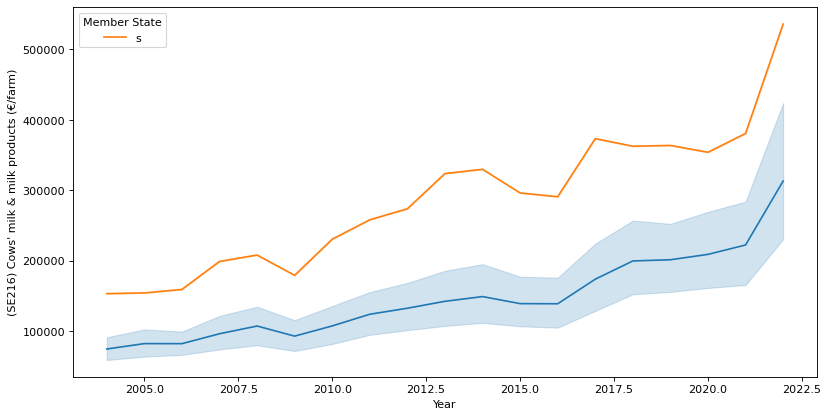

In [ ]:
figure(figsize=(12, 6), dpi=80)
sns.lineplot(x="Year", y="(SE216) Cows' milk & milk products (€/farm)", hue="Member State", data=dairy_ag_df)


In [ ]:
from dash import Dash, dcc, html, Input, Output, callback
import plotly.express as px

In [ ]:
app = Dash(__name__)

app.layout = html.Div([
    html.Div([
        dcc.Dropdown(
            id="column",
            options=dairy_ag_df.columns.tolist(),
            value="(SE085) Dairy cows (LU)",
        ),
    ], style={'width': '40%', 'display': 'inline-block'}),
    dcc.Graph(id='graph-with-slider'),
    dcc.Slider(
        dairy_ag_df.Year.min(),
        dairy_ag_df.Year.max(),
        step=None,
        value=dairy_ag_df.Year.min(),
        marks={str(year): str(year) for year in dairy_ag_df.Year.unique()},
        id='selected_year'
    )
])


@app.callback(
    Output('graph-with-slider', 'figure'),
    Input('selected_year', 'value'),
    Input('column', 'value'))
def update_figure(selected_year, column):
    filtered_df = dairy_ag_df[dairy_ag_df.Year == selected_year]

    fig = px.bar(filtered_df, x="Member State", y=column)
    fig.update_layout(transition_duration=500)

    return fig

app.run_server(debug=True, port=8054)

In [ ]:
app2 = Dash(__name__)

app2.layout = html.Div([
    html.Div([
        dcc.Dropdown(
            id="column",
            options=dairy_ag_df.columns.tolist(),
            value="(SE085) Dairy cows (LU)",
        ),
        dcc.Dropdown(
            id="state_a",
            options=dairy_ag_df['Member State'].unique(),
            value="Ireland",
        ),
        dcc.Dropdown(
            id="state_b",
            options=dairy_ag_df['Member State'].unique(),
            value="Poland",
        ),
    ], style={'width': '40%', 'display': 'inline-block'}),
    dcc.Graph(id='graph-with-slider'),
])


@app2.callback(
    Output('graph-with-slider', 'figure'),
    Input('column', 'value'),
    Input('state_a', 'value'),
    Input('state_b', 'value'),
    )
def update_figure(column, state_a, state_b):
    filtered_df = dairy_ag_df[dairy_ag_df['Member State'].isin([state_a, state_b])]

    fig = px.line(filtered_df, x="Year", y=column, color='Member State')
    fig.update_layout(transition_duration=500)

    return fig

app2.run_server(debug=True, port=8055)